## EDA
### Dataset 
Data is taken from here: https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html.

Our target labels are:
1. **Denial of Service (DoS)**: is an attack in which an adversary directed a deluge of traffic requests to a system in order to make the computing or memory resource too busy or too full to handle legitimate requests and in the process, denies legitimate users access to a machine.
2. **Probing Attack (Probe)**: probing network of computers to gather information to be used to compromise its security controls.
3. **User to Root Attack (U2R)**: a class of exploit in which the adversary starts out with access to a normal user account on the system (gained either by sniffing passwords, a dictionary attack, or social engineering) and is able to exploit some vulnerability to gain root access to the system.
4. **Remote to Local Attack (R2L)**: occurs when an attacker who has the ability to send packets to a machine over a network but who does not have an account on that machine exploits some vulnerability to gain local access as a user of that machine.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import plotly.graph_objs as go

%matplotlib inline

corrected = "./data/corrected"
kddcup_data_corrected = "./data/kddcup.data.corrected"

kddcup_data_10_percent_corrected = "./data/kddcup.data"
kddcup_testdata_10_percent = "./data/kddcup.testdata.unlabeled_10_percent"

correspondence = "./data/training_attack_types.txt"
header_files = "./data/headers"

In [2]:
dct = dict()
with open(correspondence, "r") as f:
    for line in f:
        line = line.split()
        if line != []:
            dct[line[0]] = line[1][:-1]
dct["normal"] = "normal"

In [3]:
header_files = "./data/headers"
with open(header_files, 'r') as f:
    header = f.readline().strip().split(',')

In [4]:
print(header)

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'classes']


In [5]:
df = pd.read_csv(kddcup_data_10_percent_corrected, header=None)
df.columns = header
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,classes
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [6]:
df.classes.value_counts()

smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: classes, dtype: int64

In [7]:
test_data = pd.read_csv(kddcup_testdata_10_percent, header=None)
test_data.columns = header[:-1]

In [8]:
def labels_map(label):
    """
     0 - normal
     1 - probe -  surveillance and other probing, e.g., port scanning.
     2 - dos - denial-of-service, e.g. syn flood;
     3 - u2r - unauthorized access to local superuser (root) privileges, e.g., various __buffer overflow__ attacks;
     4 - R2L - unauthorized access from a remote machine, e.g. guessing password;
    """
    label = str(label).split('.')[0]
    if label == 'normal':
        return 0
    if label in ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']: 
        return 1
    if label in ['apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm']:
        return 2
    if label in ['buffer_overflow', 'httptunnel', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']: 
        return 3
    if label in ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack',
                 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'worm', 'xlock', 'xsnoop']: 
        return 4
df['classes'] = df.classes.apply(labels_map)
test_data.classes = test_data.apply(labels_map)

In [9]:
df.classes.value_counts()

2    3883370
0     972781
1      41102
4       1126
3         52
Name: classes, dtype: int64

**Percentage distribution of class labels in dataset**

In [10]:
rows_count = df.shape[0]
df.groupby('classes').size() * 100/rows_count

classes
0    19.859032
1     0.839085
2    79.277834
3     0.001062
4     0.022987
dtype: float64

In [11]:
df.groupby(['protocol_type'])['classes'].value_counts()

protocol_type  classes
icmp           2          2808150
               0            12763
               1            12632
tcp            2          1074241
               0           768670
               1            26512
               4             1126
               3               49
udp            0           191348
               1             1958
               2              979
               3                3
Name: classes, dtype: int64

In [12]:
df.groupby(['classes'])['service'].value_counts()

classes  service  
0        http         619046
         smtp          95371
         private       73853
         domain_u      57773
         other         56520
         ftp_data      38093
         urp_i          5375
         finger         5017
         ntp_u          3833
         ftp            3821
         eco_i          3768
         ecr_i          3456
         auth           2328
         telnet         2227
         pop_3           922
         IRC             520
         time            509
         urh_i           148
         X11             129
         domain           38
         red_i             9
         ssh               7
         tim_i             7
         shell             5
         imap4             3
         tftp_u            3
1        other         15103
         eco_i         12570
         private       12279
         ecr_i            59
                       ...  
2        auth           1037
         ctf            1037
         daytime        

In [13]:
X = df[df.columns[:-1]]

In [14]:
print('The number of duplicates is {}\n'.format(X.duplicated().sum()))
print('The total numer of rows is {}'.format(X.shape[0]))

The number of duplicates is 3823457

The total numer of rows is 4898431


In [15]:
print('The number of duplicates in test is {}\n'.format(test_data.duplicated().sum()))
print('The total numer of rows in test is {}'.format(test_data.shape[0]))

The number of duplicates in test is 233813

The total numer of rows in test is 311029


In [16]:
categorial_features = ['protocol_type','service','flag','land','logged_in','is_host_login','is_guest_login']
x_categor = X.loc[:,categorial_features]

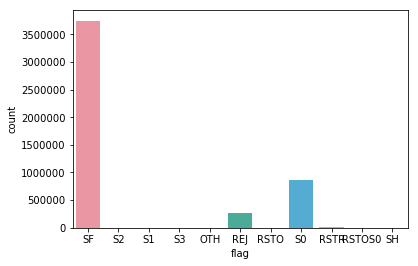

In [17]:
sns.countplot(x_categor.flag)

Can someone attack a guest profile?

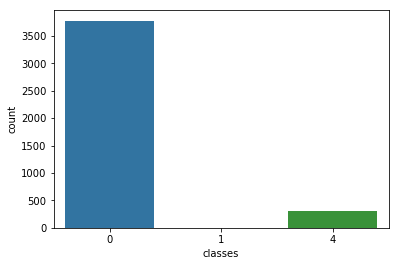

In [18]:
sns.countplot(df[(df['is_guest_login'] == 1)].classes)

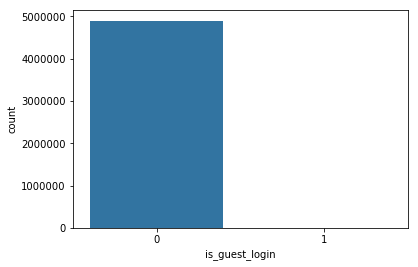

In [19]:
sns.countplot(x_categor['is_guest_login'])

Is everybody logged 

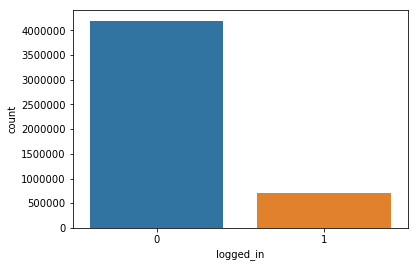

In [20]:
sns.countplot(x_categor['logged_in'])

In connection with a large number of duplicate data, we delete them.
Remove duplicate rows

In [21]:
print('rows and columns: ' + str(df.shape))
df = df.drop_duplicates()
print('rows and columns after removing duplicates:' + str(df.shape))

rows and columns: (4898431, 42)
rows and columns after removing duplicates:(1074983, 42)


The numbers of none values

In [22]:
len(df[df.isnull().any(axis=1)])

0

Let's try to find unnecessery columns. Features which will not impact on our prediction.

In [23]:
for col in np.array(df.columns):
    if len(df[col].unique()) == 1:
        print(col)

num_outbound_cmds


In [24]:
df.num_outbound_cmds.unique()

array([0], dtype=int64)

This feature has the same value in all samples.

In [25]:
df.drop('num_outbound_cmds', axis=1,inplace=True)

### Let's see to the numerical features

In [26]:
cols=list(df.axes[1].values)
x_numerical=df.loc[:,list(set(cols).difference(set(categorial_features)))]

In [27]:
x_numerical.describe()

,dst_host_count,rerror_rate,dst_host_srv_diff_host_rate,classes,wrong_fragment,dst_host_srv_rerror_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,num_root,dst_host_diff_srv_rate,...,srv_diff_host_rate,dst_bytes,srv_serror_rate,dst_host_srv_serror_rate,diff_srv_rate,num_compromised,srv_rerror_rate,dst_host_serror_rate,urgent,su_attempted
count,1.074983e+06,1.074983e+06,1.074983e+06,1.074983e+06,1.074983e+06,1.074983e+06,1.074983e+06,1.074983e+06,1.074983e+06,1.074983e+06,...,1.074983e+06,1.074983e+06,1.074983e+06,1.074983e+06,1.074983e+06,1.074983e+06,1.074983e+06,1.074983e+06,1.074983e+06,1.074983e+06
mean,1.619737e+02,7.811753e-02,2.173620e-02,4.767861e-01,2.735857e-03,7.829728e-02,7.954166e-02,9.335003e-02,5.875349e-02,4.949933e-02,...,1.179052e-01,4.873771e+03,1.908086e-01,1.901312e-01,3.159977e-02,3.570847e-02,7.793108e-02,1.906596e-01,3.627964e-05,1.674445e-04
std,1.022639e+02,2.669236e-01,5.636329e-02,8.490835e-01,8.836023e-02,2.609850e-01,2.622005e-01,2.298151e-01,8.406188e+00,1.310806e-01,...,2.655133e-01,1.376872e+06,3.916618e-01,3.913491e-01,1.169091e-01,8.232131e+00,2.659115e-01,3.907633e-01,1.540169e-02,1.725258e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.240000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,...,0.000000e+00,3.320000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.550000e+02,0.000000e+00,2.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e-02,0.000000e+00,6.000000e-02,...,9.000000e-02,1.721000e+03,0.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.550000e+02,1.000000e+00,1.000000e+00,4.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.468000e+03,1.000000e+00,...,1.000000e+00,1.309937e+09,1.000000e+00,1.000000e+00,1.000000e+00,7.479000e+03,1.000000e+00,1.000000e+00,1.400000e+01,2.000000e+00


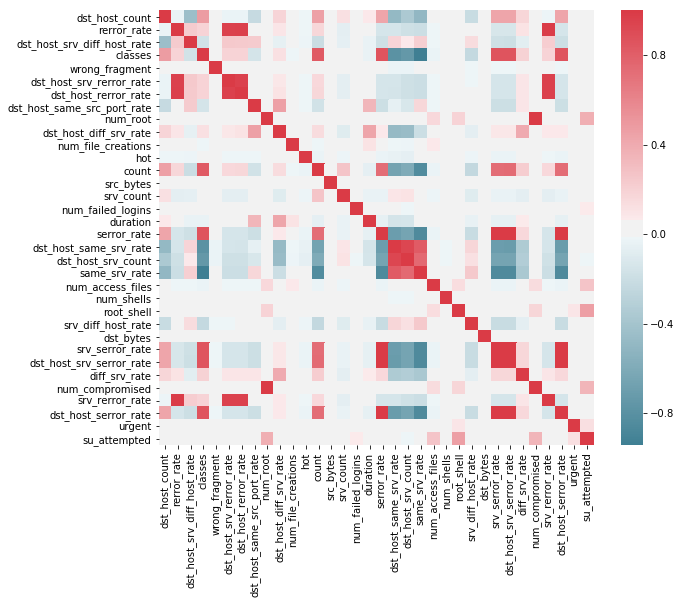

In [28]:
corr = x_numerical.corr()
f, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [29]:
pairsSet = set()

def is_only_zero_and_one(array):
    array = np.array(array.unique())
    return len(array) == 2 and ((array[0] == 0 and array[1] == 1) or ((array[0] == 1 and array[1] == 0)))

for column in x_numerical.columns:
    for inner_column in x_numerical.columns:            
        key1 = column + '-' + inner_column
        key2 = inner_column + '-' + column
        if column != inner_column and key1 not in pairsSet and key2 not in pairsSet:
            pairsSet.add(key1)
            pairsSet.add(key2)
            correlation = np.corrcoef(x_numerical[column], x_numerical[inner_column])[0, 1]
            if ((correlation >= 0.75) &  (not is_only_zero_and_one(x_numerical[column])) &  (not is_only_zero_and_one(x_numerical[inner_column]))):
                print(column + " -- " + inner_column)
                print(correlation)
                

rerror_rate -- dst_host_srv_rerror_rate
0.958523942792
rerror_rate -- dst_host_rerror_rate
0.965840002928
rerror_rate -- srv_rerror_rate
0.989590879106
classes -- count
0.828797462054
classes -- serror_rate
0.862031321779
classes -- srv_serror_rate
0.860892469498
classes -- dst_host_srv_serror_rate
0.862110229559
classes -- dst_host_serror_rate
0.86208786186
dst_host_srv_rerror_rate -- dst_host_rerror_rate
0.96124643166
dst_host_srv_rerror_rate -- srv_rerror_rate
0.959543106568
dst_host_rerror_rate -- srv_rerror_rate
0.95640162997
num_root -- num_compromised
0.997601477293
serror_rate -- srv_serror_rate
0.996829287845
serror_rate -- dst_host_srv_serror_rate
0.994938301414
serror_rate -- dst_host_serror_rate
0.995800067645
dst_host_same_srv_rate -- dst_host_srv_count
0.931814041588
dst_host_same_srv_rate -- same_srv_rate
0.822898895297
dst_host_srv_count -- same_srv_rate
0.756331355228
srv_serror_rate -- dst_host_srv_serror_rate
0.997389318958
srv_serror_rate -- dst_host_serror_rate
0.9

In [31]:
print(df.serror_rate.describe())
print(df.dst_host_srv_serror_rate.describe())
print(df.srv_serror_rate.describe())
print(df.dst_host_serror_rate.describe())
print(df.num_root.describe())
print(df.num_compromised.describe())

count    1.074983e+06
mean     1.901184e-01
std      3.909790e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: serror_rate, dtype: float64
count    1.074983e+06
mean     1.901312e-01
std      3.913491e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: dst_host_srv_serror_rate, dtype: float64
count    1.074983e+06
mean     1.908086e-01
std      3.916618e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: srv_serror_rate, dtype: float64
count    1.074983e+06
mean     1.906596e-01
std      3.907633e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: dst_host_serror_rate, dtype: float64
count    1.074983e+06
mean     5.875349e-02
std      8.406188e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75

We should remove unecessery information

In [32]:
corr_column_names = ['dst_host_srv_serror_rate', 'srv_serror_rate', 'dst_host_serror_rate']
df.drop(corr_column_names, axis=1, inplace=True)

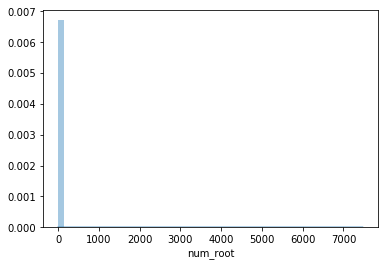

In [33]:
sns.distplot(x_numerical['num_root'])

### Translate categorial data to numeric

In [34]:
le = LabelEncoder()
need_labeling = ['protocol_type', 'service','flag']

for i in need_labeling:
    le.fit(df[i])
    df[i] = le.transform(df[i])

### **Feature selection using random forest **

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth=25, random_state=42)

In [36]:
from sklearn.model_selection import train_test_split
X = df[df.columns[:-1]]
y = df['classes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, random_state=42)


In [37]:
from sklearn.preprocessing import MinMaxScaler
def do_normalization(x_train):
    cat_features = ['protocol_type','service','flag','land','logged_in','is_host_login','is_guest_login']
    cols=list(x_train.axes[1].values)
    cont_features=list(set(cols).difference(set(cat_features)))
    scaler = MinMaxScaler()
    x_train.loc[:,cont_features]=scaler.fit_transform(x_train.loc[:,cont_features])
    return x_train
X_train = do_normalization(X_train)
X_test = do_normalization(X_test)

C:\Users\kopoden\Anaconda2\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [38]:
X_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
19539,0.0,1,24,9,2.239189e-07,1.966506e-06,0,0.0,0.0,0.0,...,0.0,0.00,0.211765,1.000000,1.00,0.00,0.02,0.07,0.0,0.0
1059795,0.0,1,54,9,1.079738e-06,2.519204e-07,0,0.0,0.0,0.0,...,0.0,0.00,0.090196,0.090196,1.00,0.00,0.04,0.00,0.0,0.0
292414,0.0,1,24,9,2.087011e-07,2.572642e-07,0,0.0,0.0,0.0,...,0.0,0.09,0.737255,1.000000,1.00,0.00,0.01,0.01,0.0,0.0
13127,0.0,1,24,9,1.623231e-07,1.485567e-06,0,0.0,0.0,0.0,...,0.0,0.00,0.043137,1.000000,1.00,0.00,0.09,0.02,0.0,0.0
497014,0.0,1,20,9,7.278451e-06,0.000000e+00,0,0.0,0.0,0.0,...,0.0,0.13,0.603922,0.278431,0.46,0.03,0.46,0.00,0.0,0.0


In [39]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [40]:
importances=[]
for (x,y) in zip((X_train.axes[1].values),rf.feature_importances_):
    importances.append([x, y])
    
print([i[0] for i in importances])

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


37

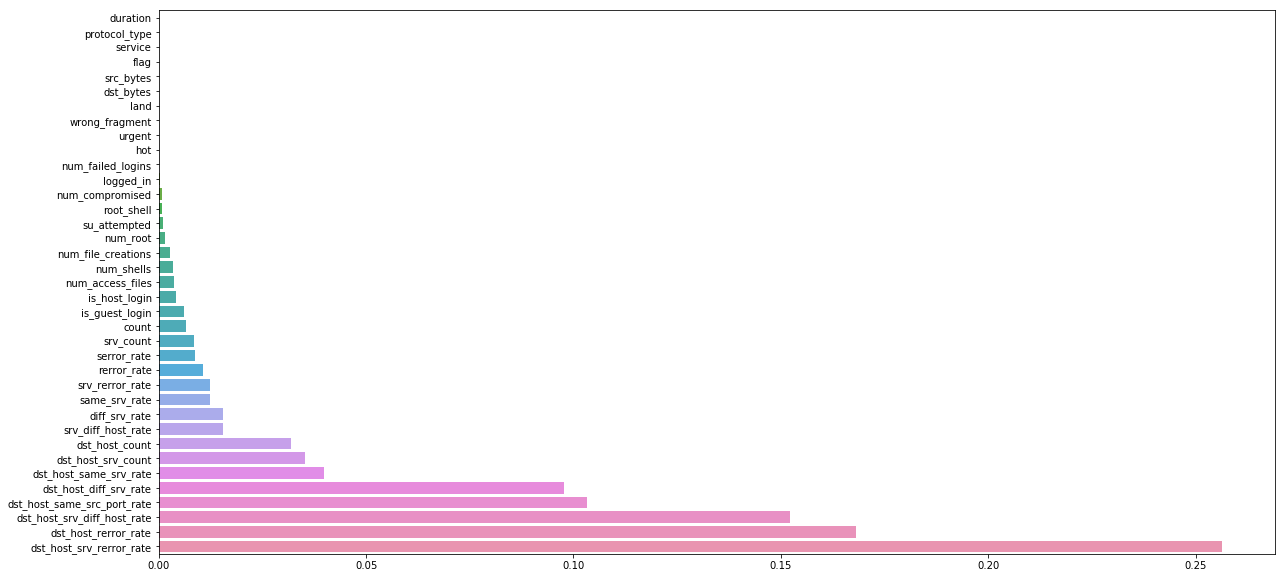

In [41]:
fig, axes = plt.subplots(figsize=(20,10))        
sns.barplot(x=np.sort([i[1] for i in importances]),y=[i[0] for i in importances])

### Save data

In [42]:
X_train.to_csv("./data/train_data")
y_train.to_csv("./data/train_labels")
X_test.to_csv("./data/test_data")
y_test.to_csv("./data/test_labels")

## Results of EDA

1. We find 1 feature that doesn't impact on target
2. 3 feature we've deleted due to high correlation 
3. Many samples had duplicate.
4. It seems that some of features are not important